# Analysis - Data generators

Behavior in high-dimensional spaces between several data generators:
- DENSIRED - ours
- MDCGen
- Seed Spreader
- make_blobs by sklearn
- gaussian quantiles by sklearn

---
# Table of contents
1. [DENSIRED](#densired)
2. [Evaluation area](#eval)
3. [Intrinsic Dimensionality](#intrinsic)
---

# Data Generator - DENSIRED <a name="densired"></a>

#### Load dependencies

In [1]:
import numpy as np
import pandas as pd
import random
import math
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
from collections import deque
from tqdm import tqdm
import seaborn as sns
sns.set

from pyparsing import nestedExpr

import warnings
warnings.filterwarnings("ignore")

#### Load DENSIRED

In [2]:
from datagen import densityDataGen

# Comparison - Evaluation area <a name="eval"></a>

#### Load dependencies

In [3]:
from sklearn.datasets import make_blobs, make_gaussian_quantiles, make_circles
from scipy import spatial
from sklearn import preprocessing
import mdcgenpy
from mdcgenpy.clusters import ClusterGenerator
from distance_metric import get_nearest_neighbors
from seed_spreader import seedSpreader

In [4]:
#plt.rcParams.update({'font.size': 50})

#### Helper fncs - metrics

In [5]:
def cosine_dist(p1, p2):
    """
    Calculate the cosine distance between to points in R^n.

    Examples
    --------
    >>> cosine_dist([1, 0], [0, 1])
    90.0
    >>> cosine_dist([1, 0], [2, 0])
    0.0
    >>> cosine_dist([1, 0], [-1, 0])
    180.0
    """
    ang = 1 - spatial.distance.cosine(p1, p2)
    if not (-1 <= ang <= 1):
        if ang >= 1:
            return 0
        if ang <= -1:
            return 180
    return np.degrees(np.arccos(ang))


# np.random.choice(np.arange(0, data_blobs[0].shape[0]), 2)
def get_angles(n, data, num_points=100):
    """Get angles of random points in n-dimensional unit hypercube."""
    # points = 2 * np.random.rand(num_points, n) - 1
    points = np.random.choice(np.arange(0, data.shape[0]-1), num_points*2)
    angles = []
    for p1 in points:
        for p2 in points:
            angles.append(cosine_dist(data[p1], data[p2]))
    return angles


def get_dc_dist(n, data, num_points=100):
    distdc = get_nearest_neighbors(data, 2, min_samples=2)['_all_dists']
    points = np.random.choice(np.arange(0, data.shape[0]-1), num_points*2)
    dists = []
    for p1 in points:
        for p2 in points:
            dists.append(distdc[p1][p2])
    return dists

# np.random.choice(np.arange(0, data_blobs[0].shape[0]), 2)
def get_euclidean_dists(n, data, num_points=100):
    """Get angles of random points in n-dimensional unit hypercube."""
    # points = 2 * np.random.rand(num_points, n) - 1
    points = np.random.choice(np.arange(0, data.shape[0]-1), num_points*2)
    dists = []
    for p1 in points:
        for p2 in points:
            dists.append(np.linalg.norm(data[p2] - data[p1]))
    return dists


In [6]:
def _norm_data(dataset):
    
    dataset = dataset - np.min(dataset)
    
    dataset = dataset / np.max(dataset)
    return dataset

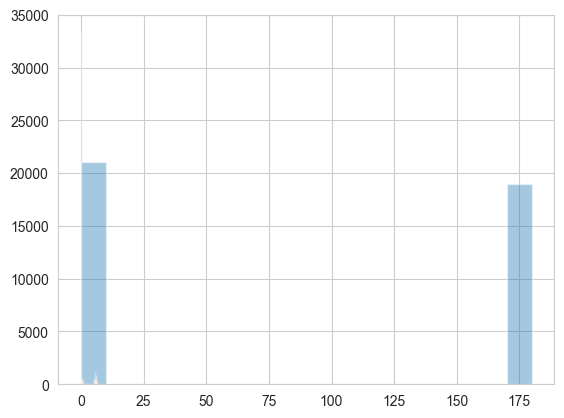

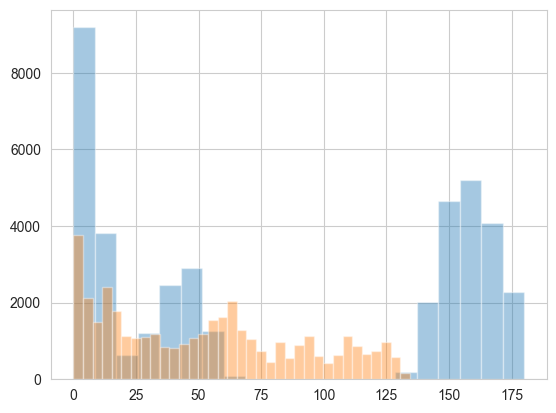

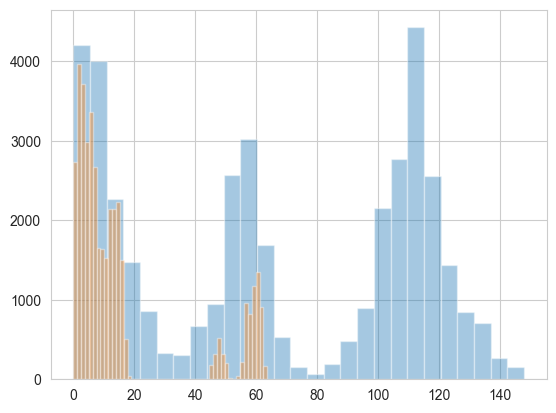

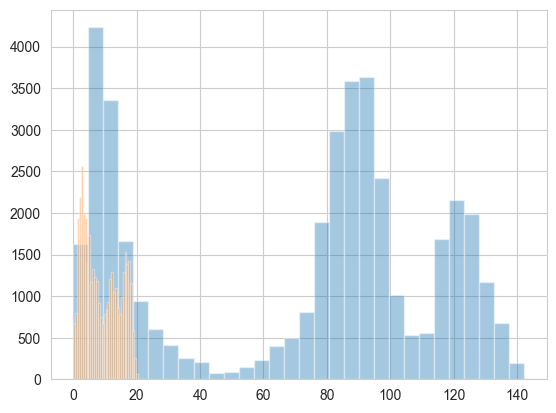

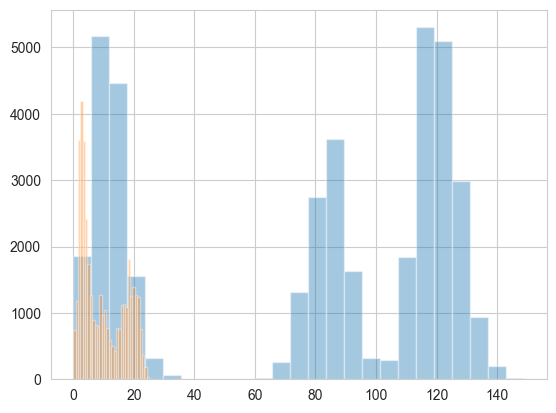

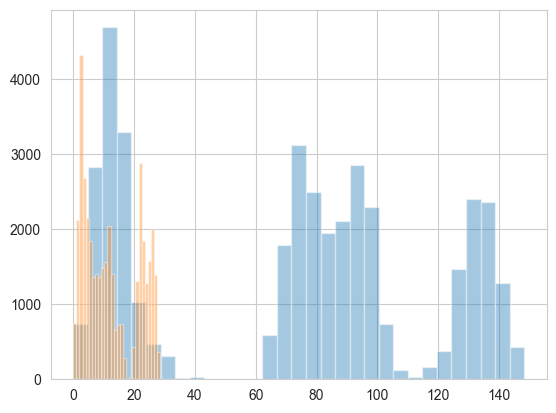

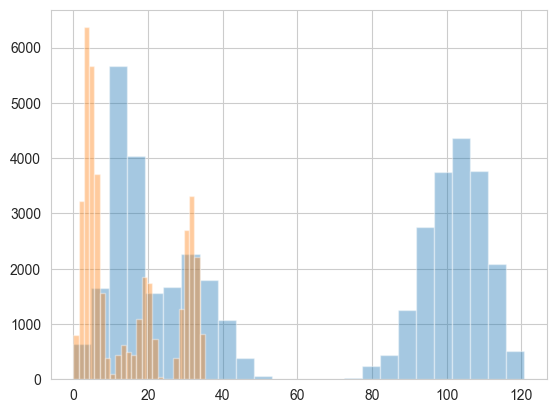

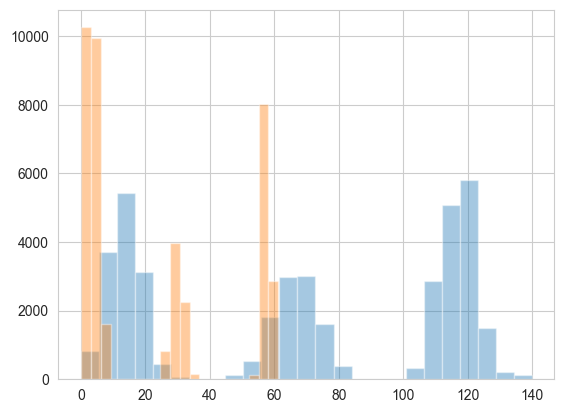

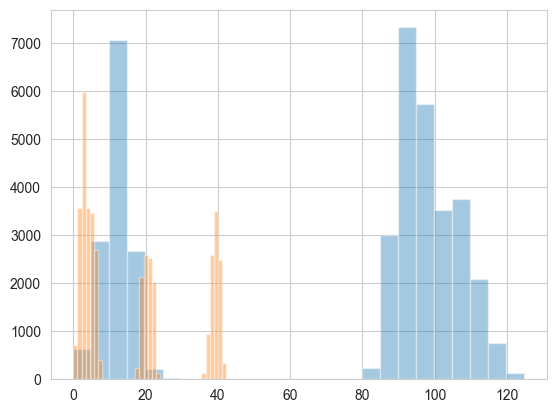

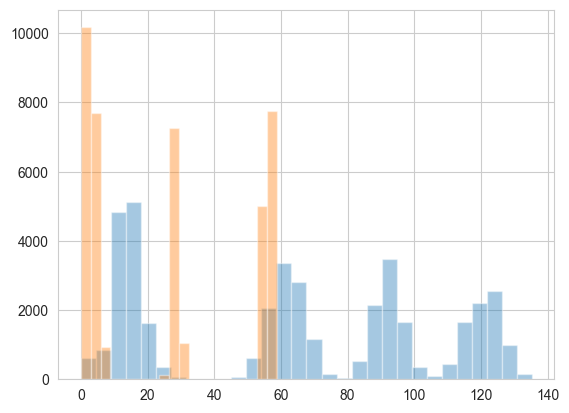

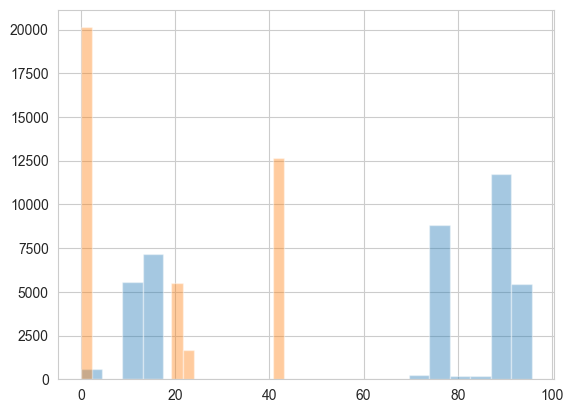

In [7]:
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]:
    n_clusters = 3
    n_samples=100
    
    data_blobs = make_blobs(n_samples=n_samples, n_features=n)
    angles_blobs = get_angles(n, data_blobs[0])

    x = densityDataGen(dim=n, ratio_noise=0, clunum= n_clusters, seed = 5)
    x_data = x.generate_data(n_samples)
    angles_dc = get_angles(n,x_data)
    #print("{:>5} dim: {:0.4f} avg angle".format(n, sum(angles) / len(angles)))
    plt.figure()
    sns.distplot(angles_blobs, kde=False, rug=False)
    sns.distplot(angles_dc, kde=False, rug=False)
    

#### Compare generators w/ various metrics

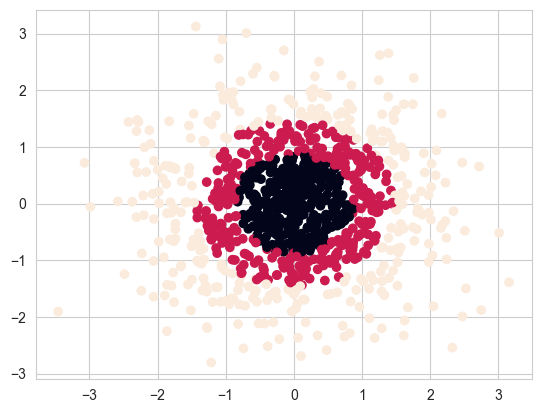

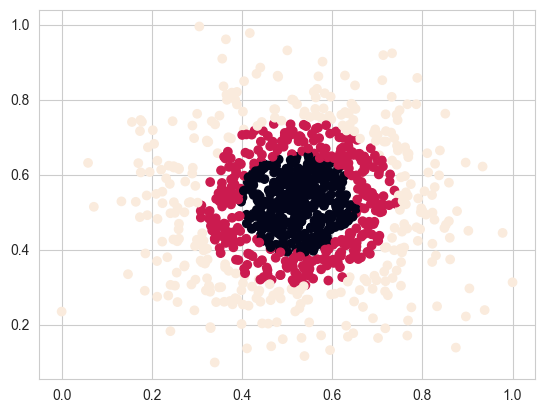

In [8]:
data_gquant = make_gaussian_quantiles(n_samples=1000, n_features=2)
gquant = data_gquant[0]
plt.scatter(x=gquant[:,0], y=gquant[:,1], c=data_gquant[1])
plt.show()

gquant_norm2 = _norm_data(gquant)
plt.scatter(x=gquant_norm2[:,0], y=gquant_norm2[:,1], c=data_gquant[1])
plt.show()

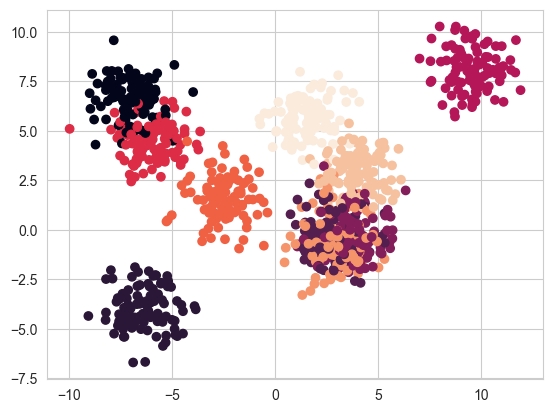

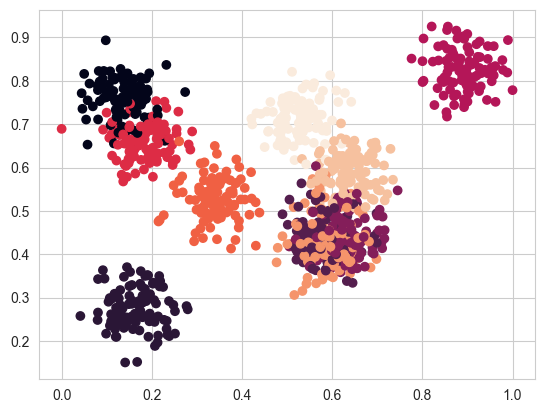

In [9]:
dataset = make_blobs(n_samples=1000, centers=10, n_features=2)
data = dataset[0]
plt.scatter(x=data[:,0], y=data[:,1], c=dataset[1])
plt.show()


data_norm2 = _norm_data(data)
plt.scatter(x=data_norm2[:,0], y=data_norm2[:,1], c=dataset[1])
plt.show()

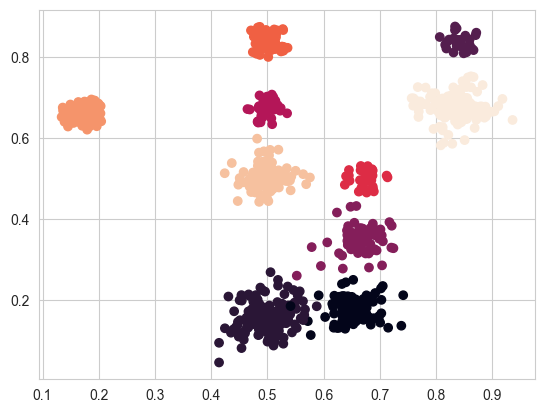

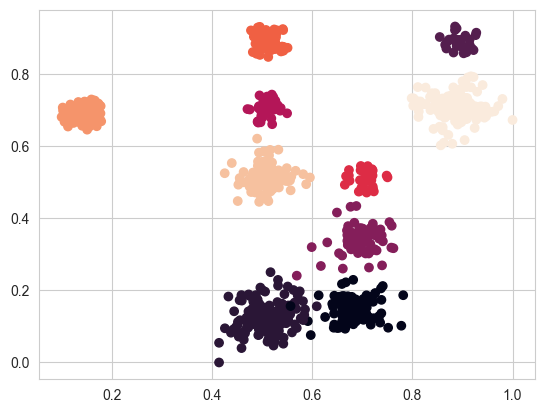

In [10]:
dataset = mdcgenpy.clusters.ClusterGenerator(n_samples=1000, n_feats=2, k=10, outliers = 0).generate_data()
data = dataset[0]
plt.scatter(x=data[:,0], y=data[:,1], c=dataset[1])
plt.show()

data_norm2 = _norm_data(data)
plt.scatter(x=data_norm2[:,0], y=data_norm2[:,1], c=dataset[1])
plt.show()

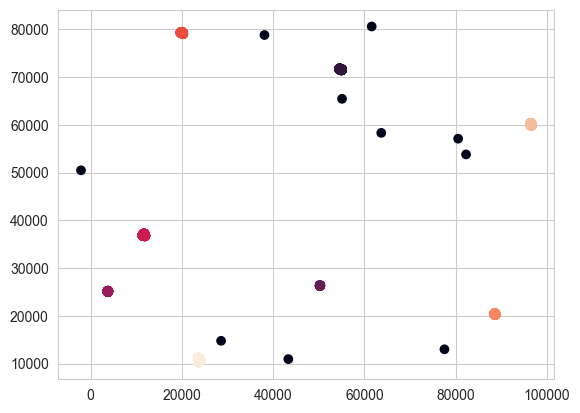

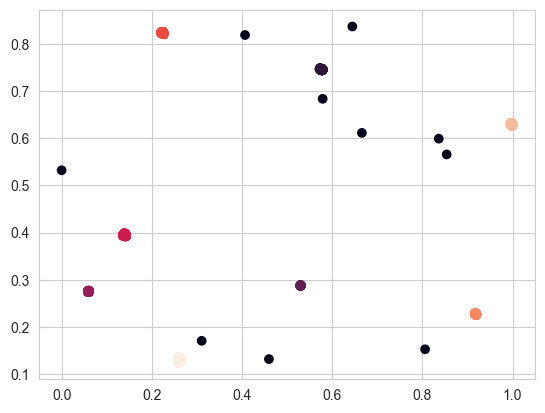

In [11]:
dataset = seedSpreader(n=10000, dim=2, noise_adapt=True)
data = dataset[0: , 0:-1]
labels = dataset[0: , -1]
plt.scatter(x=data[:,0], y=data[:,1], c=labels)
plt.show()

data_norm = _norm_data(data)
plt.scatter(x=data_norm[:,0], y=data_norm[:,1], c=labels)
plt.show()

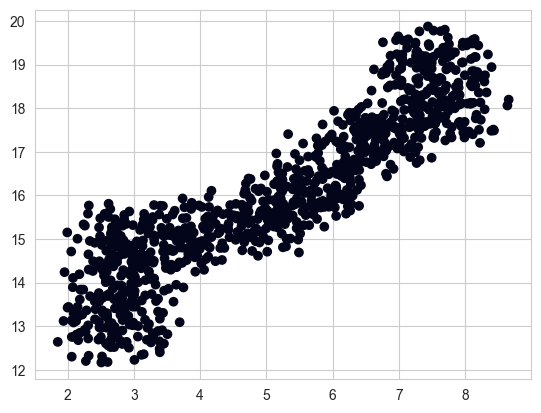

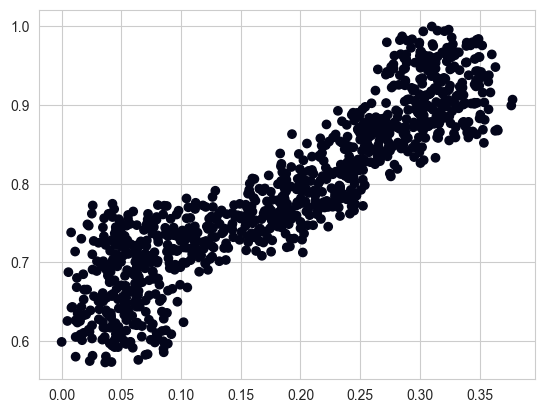

In [12]:
dg = densityDataGen(dim=2, ratio_noise=0, clunum=1, seed=42)
dataset = dg.generate_data(1000)

data = dataset[0: , 0:-1]
labels = dataset[0: , -1]
plt.scatter(x=data[:,0], y=data[:,1], c=labels)
plt.show()

data_norm2 = _norm_data(data.copy())
plt.scatter(x=data_norm2[:,0], y=data_norm2[:,1], c=labels)
plt.show()

In [40]:
def compare_generators(x_range=[10,25, 50, 100], metric="euclidean", 
                       n_iter= 5, n_clusters= 1, n_samples=1000, 
                       plot_distributions=False):
    avg_blobs = []
    avg_gaussian_quantiles = []
    avg_ddg = []
    avg_ddg_star = []
    avg_ddg_branch = []
    avg_ddg_momentum = []
    avg_mdcgen = []
    avg_revisited = []
    
    def _get_avg_dist(dataset):
        if metric == "euclidean":
            dists = get_euclidean_dists(n, dataset)
        elif metric == "cosine":
            dists = get_angles(n, dataset)
        elif metric == "dcdist":
            dists = get_dc_dist(n, dataset) # get_nearest_neighbors(dataset, 2, min_samples=2)['_all_dists']
        else:
            raise NotImplementedError(f"metric {metric} not implemented. \
            Please choose amongst 'euclidean', 'cosine', or 'dcdist'.")
        return dists
        
        #return dataset / np.linalg.norm(dataset, axis=0, keepdims=True)

    for n in tqdm(x_range):
        tmp_blob = 0
        tmp_gaussian = 0
        tmp_ddg = 0
        tmp_ddg_star = 0
        tmp_ddg_branch = 0
        tmp_ddg_mom = 0
        tmp_mdcgen = 0  
        tmp_revisited= 0

        for _ in range(n_iter):
            seed = random.randint(0,1000)

            # BLOBS
            data_blobs = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n)
            dists_blobs = _get_avg_dist(_norm_data(data_blobs[0]))
            tmp_blob += (sum(dists_blobs) / len(dists_blobs))

            # GAUSSIAN QUANTILES
            data_gquant = make_gaussian_quantiles(n_samples=n_samples, n_features=n)
            dists_gquants = _get_avg_dist(_norm_data(data_gquant[0]))
            tmp_gaussian += (sum(dists_gquants) / len(dists_gquants))

            # MDCGenerator - Felix/Arthur
            cluster_gen = mdcgenpy.clusters.ClusterGenerator(n_samples=n_samples, n_feats=n, k=n_clusters, outliers=0)
            data_mdcgen = cluster_gen.generate_data()[0]
            dists_mdcgen = _get_avg_dist(_norm_data(data_mdcgen))
            tmp_mdcgen += (sum(dists_mdcgen) / len(dists_mdcgen))     

            # Datagenerator - revisited
            step=50*n
            data_rev = seedSpreader(n=n_samples, dim=n, step=step, noise_adapt=True,  restart_chance_mult = 0, ratio_noise=0)
            dists_revisited = _get_avg_dist(_norm_data(data_rev[0: , 0:-1]))
            tmp_revisited += (sum(dists_revisited) / len(dists_revisited))
            
            # density generator - Philipp - default
            x = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, seed=seed) 
            x_data = x.generate_data(n_samples)
            dists_dc = _get_avg_dist(_norm_data(x_data[:, :-1]))
            tmp_ddg += (sum(dists_dc) / len(dists_dc))

            # density generator - Philipp - star
            x_ddg_star = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=1, branch=0.05, seed=seed)
            x_ddg_star_data = x_ddg_star.generate_data(n_samples)
            dists_dc_star = _get_avg_dist(_norm_data(x_ddg_star_data[:, :-1]))
            tmp_ddg_star += (sum(dists_dc_star) / len(dists_dc_star))

            # density generator - Philipp - branch
            x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=0, branch=1, seed=seed)
            x_ddg_branch_data = x_ddg_branch.generate_data(n_samples)
            dists_dc_branch = _get_avg_dist(_norm_data(x_ddg_branch_data[:, :-1]))
            tmp_ddg_branch += (sum(dists_dc_branch) / len(dists_dc_branch))

            # density generator - Philipp - momentum
            x_ddg_mom = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=0, branch=0.05, momentum=1.0, seed=seed)
            x_ddg_mom_data = x_ddg_mom.generate_data(n_samples)
            dists_dc_mom = _get_avg_dist(_norm_data(x_ddg_mom_data[:, :-1]))
            tmp_ddg_mom += (sum(dists_dc_mom) / len(dists_dc_mom))

            
            if plot_distributions:
                plt.figure()
                sns.distplot(dists_blobs, kde=False, rug=False, label="Blobs")
                sns.distplot(dists_gquants, kde=False, rug=False, label="Gaussian Quantiles")
                sns.distplot(dists_mdcgen, kde=False, rug=False, label="MDCGen")
                sns.distplot(dists_revisited, kde=False, rug=False, label=r"DBSCAN-rev")
                sns.distplot(dists_dc, kde=False, rug=False, label="DENSIRED")
                sns.distplot(dists_dc_star, kde=False, rug=False, label=r"DENSIRED$\ast$")
                sns.distplot(dists_dc_branch, kde=False, rug=False, label=r"DENSIRED$^b$")
                sns.distplot(dists_dc_mom, kde=False, rug=False, label=r"DENSIRED$^m$")                
                plt.legend()

        avg_blobs.append(tmp_blob / n_iter)
        avg_gaussian_quantiles.append(tmp_gaussian / n_iter)
        avg_ddg.append(tmp_ddg / n_iter)
        avg_ddg_star.append(tmp_ddg_star / n_iter)
        avg_ddg_branch.append(tmp_ddg_branch / n_iter)
        avg_mdcgen.append(tmp_mdcgen / n_iter)
        avg_revisited.append(tmp_revisited / n_iter)
        avg_ddg_momentum.append(tmp_ddg_mom / n_iter)
        
    return {'blobs': avg_blobs, 
            'gaussian_quantiles': avg_gaussian_quantiles,
            'ddg': avg_ddg, 
            'ddg_star': avg_ddg_star, 
            'ddg_branch': avg_ddg_branch,
            'ddg_mom': avg_ddg_momentum,
            'mdcgen': avg_mdcgen,
            'revisited': avg_revisited}

#### Plotting

In [41]:
def plot(values_dict, xlabel="Dimensions", ylabel="Avg cos distance", 
         x_range=[10,25, 50, 100], plot_legend=False, fname="plot.png"):
    
    no_entries = len(list(values_dict.values())[0])
    fig = plt.figure(figsize=(6, 2))
    barWidth = 0.1
    n_bars = np.arange(no_entries)
    
    br1 = [x - 3.5*barWidth for x in n_bars]
    br2 = [x - 2.5*barWidth for x in n_bars]
    br3 = [x - 1.5*barWidth for x in n_bars]
    
    br4 = [x - 0.5*barWidth for x in n_bars]
    br5 = [x + 0.5*barWidth for x in n_bars]

    br6 = [x + 1.5*barWidth for x in n_bars]
    br7 = [x + 2.5*barWidth for x in n_bars]
    br8 = [x + 3.5*barWidth for x in n_bars]

    plt.bar(br1, values_dict['blobs'], width = barWidth)
    plt.bar(br2, values_dict['gaussian_quantiles'], width= barWidth)
    plt.bar(br3, values_dict['revisited'], width=barWidth)
    plt.bar(br4, values_dict['mdcgen'], width=barWidth)
    plt.bar(br5, values_dict['ddg'], width = barWidth)
    plt.bar(br6, values_dict['ddg_star'], width=barWidth)
    plt.bar(br7, values_dict['ddg_branch'], width=barWidth)
    plt.bar(br8, values_dict['ddg_mom'], width=barWidth)

    if plot_legend:
        legend=['Blobs', 'Gaussian Quantiles', 'SeedSpreader', "MDCGen", 
                'DENSIRED', r"DENSIRED$^\ast$", r"DENSIRED$^b$", r"DENSIRED$^m$"]
        plt.legend(legend, loc="lower center",  ncol=4, bbox_to_anchor=(0.5, -0.75))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(0,no_entries))
    ax = plt.gca()
    ax.set_xticklabels(x_range[:no_entries])
    plt.savefig(fname, bbox_inches='tight')

#### Start computation for comparison

In [42]:
dims=[10, 50, 100, 250]

In [43]:
cos_values = compare_generators(x_range=dims, metric="cosine")

100%|██████████| 4/4 [01:36<00:00, 24.09s/it]


In [44]:
euclid_values = compare_generators(x_range=dims, metric="euclidean")

100%|██████████| 4/4 [00:54<00:00, 13.72s/it]


In [45]:
dc_dist_values = compare_generators(x_range=dims, metric="dcdist")

100%|██████████| 4/4 [1:13:26<00:00, 1101.51s/it]


Save results:

In [47]:
import pickle 

with open('saved_dictionary_cos_24_2.pkl', 'wb') as f:
    pickle.dump(cos_values, f)
with open('saved_dictionary_euclid_24_2.pkl', 'wb') as f:
    pickle.dump(euclid_values, f)
with open('saved_dictionary_dcdist_24.pkl_2', 'wb') as f: 
    pickle.dump(dc_dist_values, f)

#### Plot it!

#### Cosine

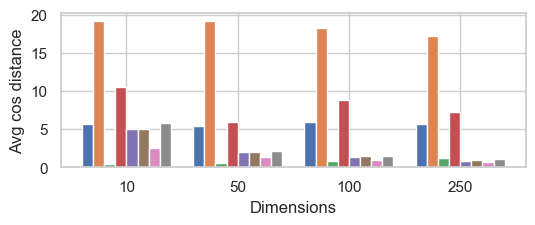

In [48]:
plot(cos_values, x_range=dims, plot_legend=False, fname="avg_cosine.png")

#### Euclidean

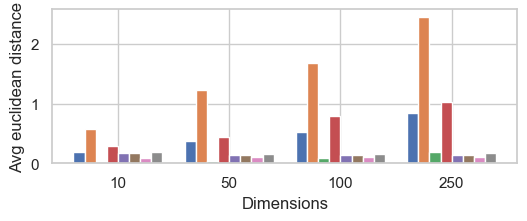

In [49]:
plot(euclid_values, x_range=dims, plot_legend=False, ylabel="Avg euclidean distance", fname="avg_euclidean.png")

#### DC Dist

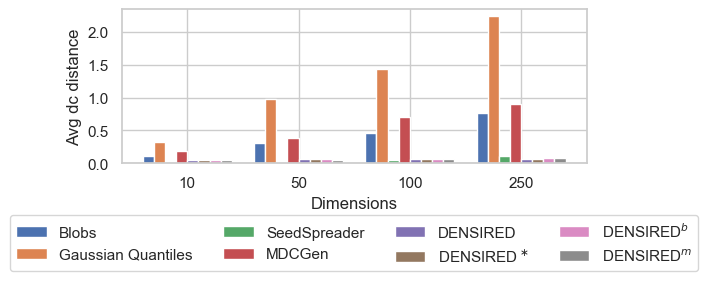

In [50]:
plot(dc_dist_values, x_range=dims, plot_legend=True, ylabel="Avg dc distance", fname="avg_dcdist.png")

#### Plotting in one row
Visualization for the paper

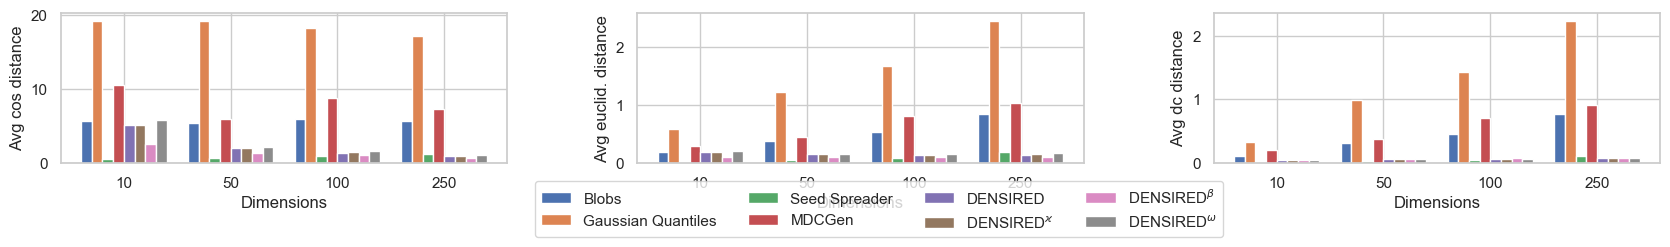

In [62]:
# x_range=[10, 100, 250, 500]
x_range = [10, 50, 100, 250]
fig, axes = plt.subplots(1,3, figsize=(18,3.5))

# plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-whitegrid')
#plt.style.use('default')

for ax, values_dict, y_label in zip(axes, 
                                    [cos_values, euclid_values, dc_dist_values], 
                                    ["Avg cos distance", "Avg euclid. distance", "Avg dc distance"]):
    no_entries = len(list(values_dict.values())[0])
    #fig = plt.figure(figsize=(6, 2))
    barWidth = 0.1
    n_bars = np.arange(no_entries)

    br1 = [x - 3.5*barWidth for x in n_bars]
    br2 = [x - 2.5*barWidth for x in n_bars]
    br3 = [x - 1.5*barWidth for x in n_bars]
    
    br4 = [x - 0.5*barWidth for x in n_bars]
    br5 = [x + 0.5*barWidth for x in n_bars]

    br6 = [x + 1.5*barWidth for x in n_bars]
    br7 = [x + 2.5*barWidth for x in n_bars]
    br8 = [x + 3.5*barWidth for x in n_bars]
    
    ax.bar(br1, values_dict['blobs'], width = barWidth)
    ax.bar(br2, values_dict['gaussian_quantiles'], width= barWidth)
    ax.bar(br3, values_dict['revisited'], width=barWidth)
    ax.bar(br4, values_dict['mdcgen'], width=barWidth)
    ax.bar(br5, values_dict['ddg'], width = barWidth)
    ax.bar(br6, values_dict['ddg_star'], width=barWidth)
    ax.bar(br7, values_dict['ddg_branch'], width=barWidth)
    ax.bar(br8, values_dict['ddg_mom'], width=barWidth)

    #if plot_legend:
    #    legend=['Blobs', 'Gaussian Quantiles', 'DENSIRED', r"DENSIRED$^\ast$", r"DENSIRED$^b$", "MDCGen"]
    #    plt.legend(legend, loc="lower center",  ncol=3, bbox_to_anchor=(0.5, -0.75))
    ax.set_xlabel("Dimensions")
    ax.set_ylabel(y_label)
    #plt.xticks(np.arange(0,no_entries))
    ax.set_xticks(np.arange(0,no_entries))
    # ax = plt.gca()
    ax.set_xticklabels(x_range[:no_entries])

legend=['Blobs', 'Gaussian Quantiles', 'Seed Spreader', "MDCGen", 'DENSIRED', r"DENSIRED$^\varkappa$", r"DENSIRED$^\beta$", r"DENSIRED$^\omega$"]
plt.tight_layout()
plt.legend(legend, loc="lower center",  ncol=4, bbox_to_anchor=(-0.75, -0.55))
plt.savefig("motivation_small_1.png", bbox_inches='tight')

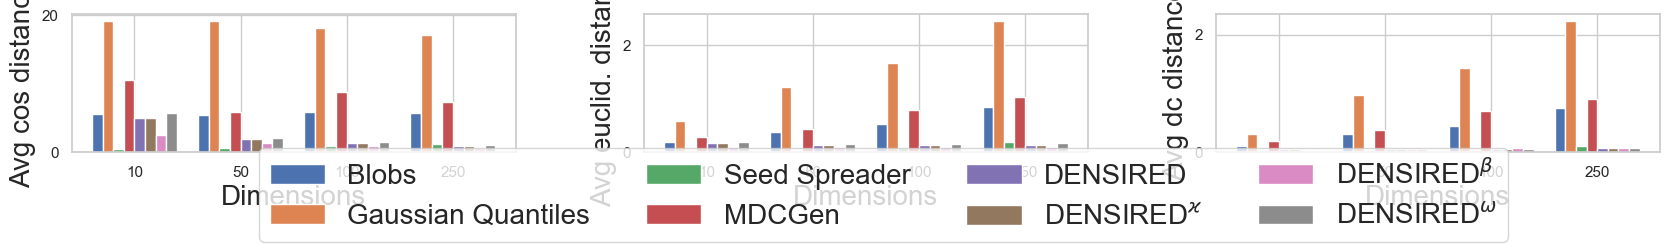

In [63]:
# x_range=[10, 100, 250, 500]
x_range = [10, 50, 100, 250]
fig, axes = plt.subplots(1,3, figsize=(18,3.5))

# plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-whitegrid')
#plt.style.use('default')

for ax, values_dict, y_label in zip(axes, 
                                    [cos_values, euclid_values, dc_dist_values], 
                                    ["Avg cos distance", "Avg euclid. distance", "Avg dc distance"]):
    no_entries = len(list(values_dict.values())[0])
    #fig = plt.figure(figsize=(6, 2))
    barWidth = 0.1
    n_bars = np.arange(no_entries)

    br1 = [x - 3.5*barWidth for x in n_bars]
    br2 = [x - 2.5*barWidth for x in n_bars]
    br3 = [x - 1.5*barWidth for x in n_bars]
    
    br4 = [x - 0.5*barWidth for x in n_bars]
    br5 = [x + 0.5*barWidth for x in n_bars]

    br6 = [x + 1.5*barWidth for x in n_bars]
    br7 = [x + 2.5*barWidth for x in n_bars]
    br8 = [x + 3.5*barWidth for x in n_bars]
    
    ax.bar(br1, values_dict['blobs'], width = barWidth)
    ax.bar(br2, values_dict['gaussian_quantiles'], width= barWidth)
    ax.bar(br3, values_dict['revisited'], width=barWidth)
    ax.bar(br4, values_dict['mdcgen'], width=barWidth)
    ax.bar(br5, values_dict['ddg'], width = barWidth)
    ax.bar(br6, values_dict['ddg_star'], width=barWidth)
    ax.bar(br7, values_dict['ddg_branch'], width=barWidth)
    ax.bar(br8, values_dict['ddg_mom'], width=barWidth)

    #if plot_legend:
    #    legend=['Blobs', 'Gaussian Quantiles', 'DENSIRED', r"DENSIRED$^\ast$", r"DENSIRED$^b$", "MDCGen"]
    #    plt.legend(legend, loc="lower center",  ncol=3, bbox_to_anchor=(0.5, -0.75))
    ax.set_xlabel("Dimensions", fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    #plt.xticks(np.arange(0,no_entries))
    ax.set_xticks(np.arange(0,no_entries))
    # ax = plt.gca()
    ax.set_xticklabels(x_range[:no_entries])

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
legend=['Blobs', 'Gaussian Quantiles', 'Seed Spreader', "MDCGen", 'DENSIRED', r"DENSIRED$^\varkappa$", r"DENSIRED$^\beta$", r"DENSIRED$^\omega$"]
plt.tight_layout()
plt.legend(legend, loc="lower center",  ncol=4, bbox_to_anchor=(-0.75, -0.75), fontsize=20)
plt.savefig("motivation_small_1.png", bbox_inches='tight')

# Intrinsic Dimensionality <a name="intrinsic"></a>

Analysis for the behavior of DENSIRED in 4 various settings:
- DENSIRED: default setting
- DESNIRED$^\varkappa$: star setting $\varkappa=1$
- DENSIRED$^\beta$: branching $\beta=0.15$
- DENSIRED$^\omega$: momentum $\omega=1$
- DENSIRED$^\delta$: step size $\delta=2$

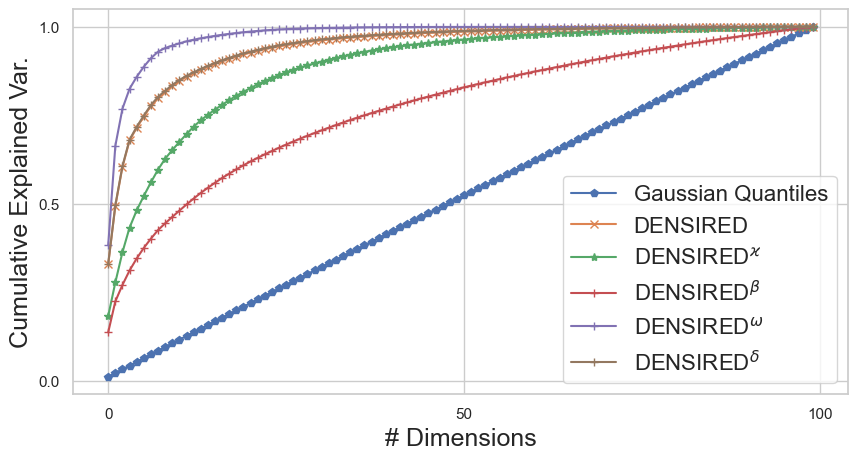

In [15]:
from sklearn.decomposition import PCA
import matplotlib

n_samples=100_000
n=100
seed=42

sns.set_theme(style="whitegrid")

#fig = plt.figure(figsize=(24,8))

f, axes = plt.subplots(1,1, figsize=(10,5), sharey=True)
# axes[0].set_ylabel('cumulative explained variance')
for ax, n_clusters in zip([axes],[1]): #5,25,50,100]):
    ax.set_ylabel("Cumulative Explained Var.", fontsize=18)
    ax.set_xlabel("# Dimensions", fontsize=18)
    #ax.set_title(f"Number of clusters: {n_clusters}")

    if False:
        # BLOBS
        data_blobs = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n)
        data_blobs = _norm_data(data_blobs[0])
        pca = PCA().fit(data_blobs)
        ax.plot(np.cumsum(pca.explained_variance_ratio_), "o-", label="Blobs")
    
    
    # GAUSSIAN QUANTILES
    data_gquant = make_gaussian_quantiles(n_samples=n_samples, n_features=n)
    data_gquant = _norm_data(data_gquant[0])
    pca = PCA().fit(data_gquant)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "p-", label="Gaussian Quantiles")
        
    if False:
        # MDCGenerator 
        cluster_gen = mdcgenpy.clusters.ClusterGenerator(n_samples=n_samples, n_feats=n, k=n_clusters)
        data_mdcgen = cluster_gen.generate_data()[0]
        data_mdcgen = _norm_data(data_mdcgen)
        pca = PCA().fit(data_mdcgen)
        ax.plot(np.cumsum(pca.explained_variance_ratio_), "d-", label="MDC")
        
    # density generator - default
    x = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, seed=seed, star=0, branch=0.05, momentum=0.5, core_num=1000, random_start = False) 
    # x = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, core_num=20*n_clusters, seed=seed) 
    x_data = x.generate_data(n_samples)
    x_data = _norm_data(x_data[:, :-1])
    pca = PCA().fit(x_data)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "x-" , label="DENSIRED")
    
    # density generator - star
    x_ddg_star = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=1, branch=0.05, momentum=0.5, core_num=1000, seed=seed, random_start = False)
    # x_ddg_star = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, core_num=20*n_clusters, star=1, branch=0.2, seed=seed)
    x_ddg_star_data = x_ddg_star.generate_data(n_samples)
    x_ddg_star_data = _norm_data(x_ddg_star_data[:, :-1])
    pca = PCA().fit(x_ddg_star_data)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "*-", label=r"DENSIRED$^\varkappa$")
    
    # density generator - branch
    x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=0, branch=1, momentum=0.5, core_num=1000, seed=seed, random_start = False)
    # x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, core_num=20*n_clusters, star=0, branch=0.2, seed=seed)
    x_ddg_branch_data = x_ddg_branch.generate_data(n_samples)
    x_ddg_branch_data = _norm_data(x_ddg_branch_data[:, :-1])
    pca = PCA().fit(x_ddg_branch_data)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "+-", label=r"DENSIRED$^\beta$")
    
    # density generator - momentum
    x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=0, branch=0.05, momentum=1.0, core_num=1000, seed=seed, random_start = False)
    # x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, core_num=20*n_clusters, star=0, branch=0.2, seed=seed)
    x_ddg_branch_data = x_ddg_branch.generate_data(n_samples)
    x_ddg_branch_data = _norm_data(x_ddg_branch_data[:, :-1])
    pca = PCA().fit(x_ddg_branch_data)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "+-", label=r"DENSIRED$^\omega$")

    # density generator - step
    x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=0, branch=0.05, momentum=0.5, core_num=1000, step=2, seed=seed, random_start = False)
    # x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, core_num=20*n_clusters, star=0, branch=0.2, seed=seed)
    x_ddg_branch_data = x_ddg_branch.generate_data(n_samples)
    x_ddg_branch_data = _norm_data(x_ddg_branch_data[:, :-1])
    pca = PCA().fit(x_ddg_branch_data)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "+-", label=r"DENSIRED$^\delta$")

plt.rcParams['xtick.labelsize'] = 42
plt.rcParams['ytick.labelsize'] = 42

# plt.legend(loc='center', bbox_to_anchor=(0, 0), fancybox=True, shadow=False, ncol=5)
plt.legend(fontsize=16)
plt.savefig("explainedVar_PCA.pdf", bbox_inches="tight")

#### Load dataset w/ intrinsic dims

In [ ]:
from sklearn.decomposition import PCA

n_samples=5000
n=128
seed=42
n_clusters=1
var_threshold=0.9

fig = plt.figure(figsize=(4,4))


f, ax = plt.subplots(1,1, figsize=(15,5), sharey=True)
axes[0].set_ylabel('cumulative explained variance')

res_blobs = []
res_gaussian = []
res_mdc = []
res_densired = []
res_densired_star = []
res_densired_branch = []

n_features=[4, 8, 16, 32, 64, 128, 256]
for idx, n in enumerate(n_features):
    ax.set_xlabel("#dimensions")
    ax.set_title(f"Number of clusters: {n_clusters}")
    
    # BLOBS
    data_blobs = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n)
    data_blobs = _norm_data(data_blobs[0])
    pca = PCA().fit(data_blobs)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_blobs.append(first_idx)
    # ax.scatter(idx, first_idx, label="Blobs")
    
    # GAUSSIAN QUANTILES
    data_gquant = make_gaussian_quantiles(n_samples=n_samples, n_features=n)
    data_gquant = _norm_data(data_gquant[0])
    pca = PCA().fit(data_gquant)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_gaussian.append(first_idx)
    # ax.scatter(idx, first_idx, label="Gaussian Quantiles")
        
    # MDCGenerator - Felix/Arthur
    cluster_gen = mdcgenpy.clusters.ClusterGenerator(n_samples=n_samples, n_feats=n, k=n_clusters)
    data_mdcgen = cluster_gen.generate_data()[0]
    data_mdcgen = _norm_data(data_mdcgen)
    pca = PCA().fit(data_mdcgen)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_mdc.append(first_idx)
    # ax.scatter(idx, first_idx, label="MDC")
        
    # density generator - Philipp - default
    x = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, seed=seed, momentum=0, core_num=100, random_start = False ) 
    x_data = x.generate_data(n_samples)
    print (x_data.shape)
    x_data = _norm_data(x_data[:, :-1])
    pca = PCA().fit(x_data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_densired.append(first_idx)
    # ax.scatter(idx, first_idx, label="DENSIRED")
    
    # density generator - Philipp - star
    x_ddg_star = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=1, branch=0.05, momentum=0.1, core_num=100, seed=seed, random_start = False )
    x_ddg_star_data = x_ddg_star.generate_data(n_samples)
    x_ddg_star_data= _norm_data(x_ddg_star_data[:, :-1])
    pca = PCA().fit(x_ddg_star_data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_densired_star.append(first_idx)
    # ax.scatter(idx, first_idx, label=r"DENSIRED$\ast$")
    
    # density generator - Philipp - branch
    x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=0, branch=1, momentum=0.1, core_num=100, seed=seed, random_start = False )
    x_ddg_branch_data = x_ddg_branch.generate_data(n_samples)
    x_ddg_branch_data = _norm_data(x_ddg_branch_data[:, :-1])
    pca = PCA().fit(x_ddg_branch_data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_densired_branch.append(first_idx)
    # ax.scatter(idx, first_idx, label=r"DENSIRED$^b$")

x_ticks=np.arange(len(n_features))
ax.plot(x_ticks, res_blobs, marker="x", label="Blobs")
ax.plot(x_ticks, res_gaussian, marker="o", label="Gaussian Quantiles")
ax.plot(x_ticks, res_mdc, marker="|", label="MDC")
ax.plot(x_ticks, res_densired, marker="^", label="DENSIRED")
ax.plot(x_ticks, res_densired_star, marker="d", label=r"DENSIRED^$\varkappa$")
ax.plot(x_ticks, res_densired_branch, marker="D", label=r"DENSIRED$^\beta$")
# ax.set_xticks(n_features)
ax.set_xticklabels([0]+n_features)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=6)
plt.savefig("explainedVar2_PCA.png", bbox_inches="tight")

In [17]:
intrinsic_dim = pd.read_csv("results/intrinsic_dim_merged.csv")
intrinsic_dim.columns
intrinsic_dim.head(25)

,cores,step,branch,star,momentum,seed,id 25,id 50,id 75,id 90,id 95,id 99
0,100,1.00,0.05,0.0,0.5,0,1,1,3,7,11,57
1,100,1.25,0.05,0.0,0.5,0,1,1,3,6,9,39
2,100,1.50,0.05,0.0,0.5,0,1,1,3,6,9,29
3,100,1.75,0.05,0.0,0.5,0,1,1,3,6,9,24
4,100,2.00,0.05,0.0,0.5,0,1,1,3,6,9,22
5,500,1.00,0.05,0.0,0.5,0,1,3,6,13,21,50
6,500,1.25,0.05,0.0,0.5,0,1,3,6,13,20,47
7,500,1.50,0.05,0.0,0.5,0,1,3,6,12,20,45
8,500,1.75,0.05,0.0,0.5,0,1,3,6,12,20,45
9,500,2.00,0.05,0.0,0.5,0,1,3,6,12,20,44


### Plotting

#### Intrinsic Dimension - momentum $\omega$

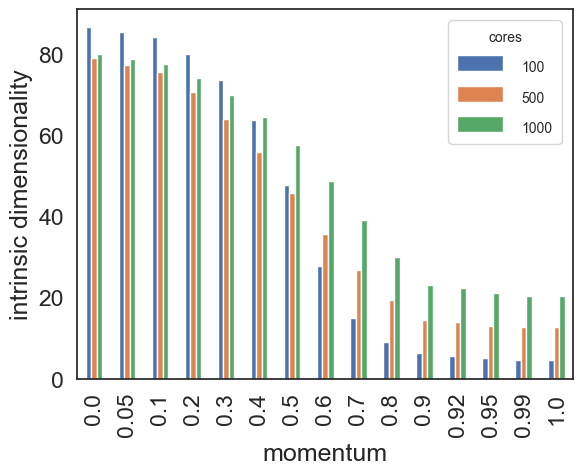

In [18]:
sns.set_theme(style="white", font_scale=1.5)
grouped_cores = intrinsic_dim[(intrinsic_dim['star']==0.0) & 
                              (intrinsic_dim['branch']==0.05) &
                              (intrinsic_dim['step']==1.0)] 
# print(grouped_cores.head(50))
df_pivot_stick = pd.pivot_table(
    grouped_cores, 
    values="id 99", 
    index="momentum", 
    columns="cores", 
    aggfunc=np.mean
)
ax = df_pivot_stick.plot(kind="bar", ylabel="intrinsic dimensionality")
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10') # for legend title
plt.savefig("intrinsic_dim_stick_new.png", bbox_inches="tight")

#### Intrinsic Dimension - branch factor $\beta$

cores   100   500   1000
branch                  
0.000   25.4  24.6  28.7
0.001   25.9  25.2  29.4
0.010   30.1  28.8  37.9
0.025   33.9  35.2  45.1
0.050   47.8  45.7  57.5
0.100   53.2  51.7  64.2
0.150   65.1  63.9  72.2
0.200   71.9  69.7  77.0
0.250   74.9  73.3  80.4
0.300   77.9  77.2  82.2
0.350   83.5  82.4  86.1
0.400   85.3  85.0  87.9
0.450   86.7  86.7  89.4
0.500   88.0  88.8  90.7


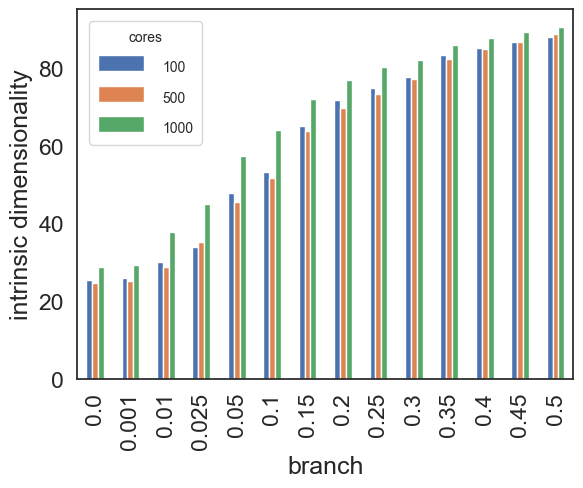

In [19]:
# grouped_cores = intrinsic_dim.groupby(["cores", "branch"])["intrinsic dim"].mean()
grouped_cores = intrinsic_dim[(intrinsic_dim['star']==0.0) & 
                              (intrinsic_dim['momentum']==0.5) &
                              (intrinsic_dim['step']==1.0)]
df_pivot_branch = pd.pivot_table(
    grouped_cores[grouped_cores['branch'] != 0.0001], 
    values="id 99", 
    index="branch", 
    columns="cores", 
    aggfunc=np.mean
)
print(df_pivot_branch)
ax = df_pivot_branch.plot(kind="bar", ylabel="intrinsic dimensionality")
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10') # for legend title
plt.savefig("intrinsic_dim_branch_new.png", bbox_inches="tight")

#### Intrinsic Dimension - star factor $\varkappa$

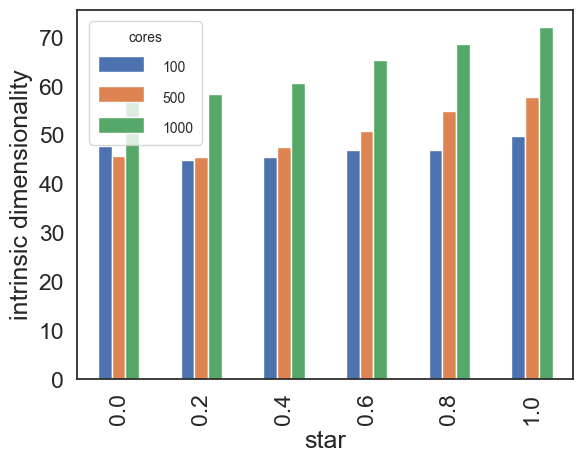

In [20]:
# grouped_cores = intrinsic_dim.groupby(["cores", "star"])["intrinsic dim"].mean()
grouped_cores = intrinsic_dim[(intrinsic_dim['branch']==0.05) & 
                              (intrinsic_dim['momentum']==0.5) &
                              (intrinsic_dim['step']==1.0)]
df_pivot_star = pd.pivot_table(
    grouped_cores, 
    values="id 99", 
    index="star", 
    columns="cores", 
    aggfunc=np.mean
)
ax = df_pivot_star.plot(kind="bar", ylabel="intrinsic dimensionality")
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10') # for legend title
plt.savefig("intrinsic_dim_star_new.png", bbox_inches="tight")

#### Intrinsic Dimension - step size $\delta$

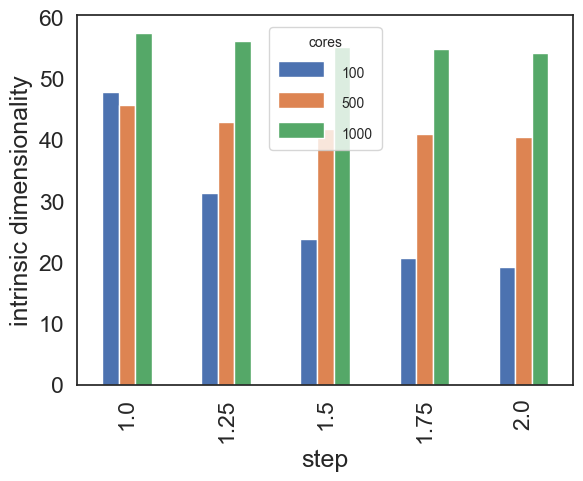

In [21]:
# grouped_cores = intrinsic_dim.groupby(["cores", "star"])["intrinsic dim"].mean()
grouped_cores = intrinsic_dim[(intrinsic_dim['branch']==0.05) & 
                              (intrinsic_dim['momentum']==0.5) &
                              (intrinsic_dim['star']==0.0)]
df_pivot_step = pd.pivot_table(
    grouped_cores, 
    values="id 99", 
    index="step", 
    columns="cores", 
    aggfunc=np.mean
)
ax = df_pivot_step.plot(kind="bar", ylabel="intrinsic dimensionality")
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10') # for legend title
plt.savefig("intrinsic_dim_step_new.png", bbox_inches="tight")

### Plot in 1 row
Visualization for the paper

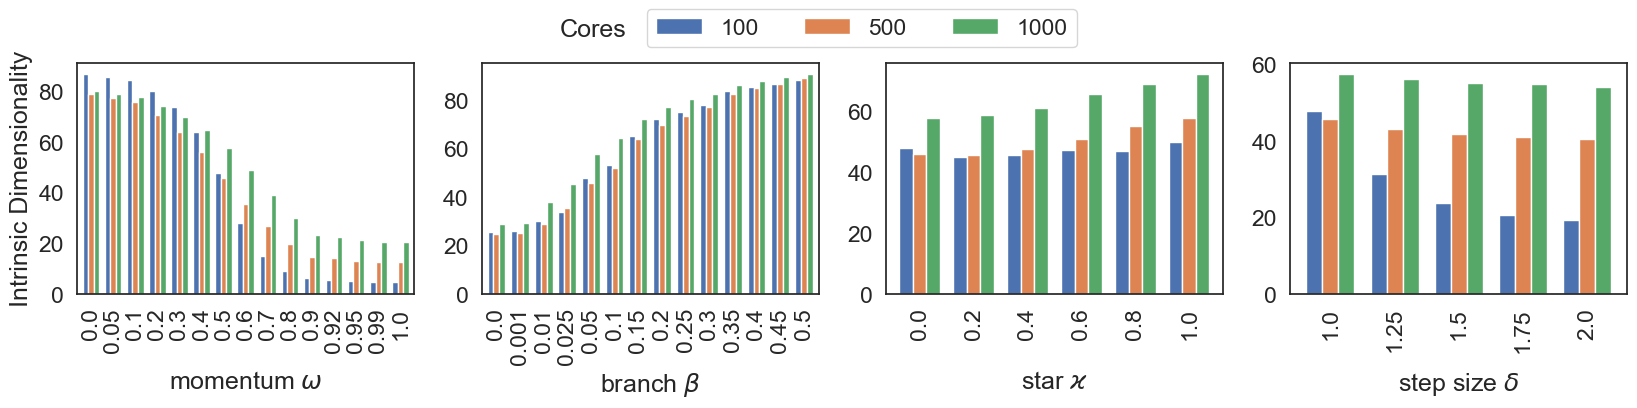

In [36]:
fig, axes = plt.subplots(1,4, figsize=(20,3))

for idx, (t, ax) in enumerate(zip([df_pivot_stick, df_pivot_branch, df_pivot_star, df_pivot_step], axes)):
    inter_a = t.plot(ax=ax, kind="bar", ylabel="Intrinsic Dimensionality", legend="", width=0.75)
    if idx > 0:
        inter_a.set_ylabel("")
    if idx==0:
        inter_a.set_xlabel(r"momentum $\omega$")
    if idx==1:
        inter_a.set_xlabel(r"branch $\beta$")
    if idx==2:
        inter_a.set_xlabel(r"star $\varkappa$")
    if idx==3:
        inter_a.set_xlabel(r"step size $\delta$")
legend=['100', '500', '1000']
plt.text(-12, 67.5, "Cores") #', (-0.7,1.1))
plt.tight_layout()
plt.legend(legend, loc="right",  ncol=3, bbox_to_anchor=(-0.6, 1.15)) #, title="Cores")
fig.align_labels()
plt.savefig("intrinsic_dim_all_final.png", bbox_inches="tight")

## Seed Spreader
From paper DBSCAN revisited revisited

In [ ]:
dim=2
step=50*dim
data = seedSpreader(dim=2, step=step, verbose=False, noise_adapt=True)

print(data)
datax = data[:, 0:-1]
print(datax.shape)
datay = data[:, -1]
print(datay.shape)

plt.figure(figsize=(15, 15))
color = plt.cm.tab20(np.linspace(0, 1, len(np.unique(datay))))
color = np.append(color, [[0, 0, 0, 1]], axis=0)
    #print(color)
plt.scatter(datax[:, 0], datax[:, 1], c=color[datay.astype('int32')])
plt.axis('scaled')
# plt.show()

### End of this notebook